---
# **機械学習特論　第9回課題**
## **【ニューラルネットワーク】Iris・MNIST・Fashion-MNISTの分類**
---

In [1]:
# ライブラリの読み込み
# %pip install --upgrade pip
# %pip install numpy
# %pip install matplotlib
# %pip install pandas
# %pip install openpyxl
# %pip install sympy
# %pip install scipy
# %pip install re
# %pip install jaconv
# %pip install scikit-learn
# %pip install statsmodels
# %pip install seaborn
# %pip install pmdarima
# %pip install kneed
# %pip install scikit-learn-intelex
# %pip install lightgbm

from matplotlib.font_manager import FontProperties
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
import sympy as sp
import scipy.stats as stats
import re
# import jaconv
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import itertools
import matplotlib.dates as mdates
# import pmdarima as pm
from IPython.display import clear_output
from sklearn.metrics import r2_score, f1_score, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
# from kneed import KneeLocator
from sklearn.decomposition import PCA
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import time
from matplotlib.ticker import LogLocator, LogFormatter
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn import metrics
from sklearn.datasets import load_iris
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning
# from sklearnex import patch_sklearn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
import os
import tensorflow as tf
from sklearn import preprocessing
from tensorflow.keras.layers import Conv1D, Conv2D, Flatten, Dense, MaxPooling2D, MaxPooling1D

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='seaborn')
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning, message=".*dask-expr is not installed.*")
warnings.filterwarnings("ignore", category=FutureWarning, module="dask.dataframe")


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


2.17.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 1. 課題
#### (1) データセット
- Irisのデータセット  
- MNIST（手書き数字）のデータセット
- Fashion-MNIST（衣類）のデータセット

In [2]:
# sklearnデータセットに収録されたiris(アヤメ)のデータセットをロードしてデータフレームを作成
def load_iris_data():
    data = load_iris()
    x = pd.DataFrame(data["data"],columns=data["feature_names"])
    y = pd.DataFrame(data["target"],columns=["target"])
    x_train, x_test, y_train, y_test  = train_test_split(x, y, test_size=0.2, random_state=1, stratify=y)
    return x_train, x_test, y_train, y_test

# 手書き文字のデータセットをダウンロードして、実験用データを準備
def load_mnist_data():
    data = fetch_openml('mnist_784', version=1)
    x = np.array(data['data'].astype(np.float32))
    y = np.array(data['target'].astype(np.int32))
    x_train, x_test, y_train, y_test  = train_test_split(x, y, test_size=0.2, random_state=1, stratify=y)
    return x_train, x_test, y_train, y_test

# Fashion-MNISTデータセットをダウンロードして、実験用データを準備
def load_fashion_mnist_data():
    data = fetch_openml('Fashion-MNIST')
    x = np.array(data['data'].astype(np.float32))
    y = np.array(data['target'].astype(np.int32))
    x_train, x_test, y_train, y_test  = train_test_split(x, y, test_size=0.2, random_state=1, stratify=y)
    return x_train, x_test, y_train, y_test

# 一括処理のためにデータセットの辞書を作成
dataset = {'iris': load_iris_data(), 'mnist': load_mnist_data(), 'fashon-mnist': load_fashion_mnist_data()}

#### (2) 分類モデル
##### ・k近傍法（kNN）
　説明変数に関する空間上の距離に従って，分類する手法である．ここで，$ k $は近くにある$ k $個のデータに従いクラスを決定することを意味する．$ k $が小さいとノイズに弱くなるが，大きすぎると精度が悪くなることが知られている．
##### ・サポートベクターマシン（SVM）
　対象データを2クラスに識別する手法である．一方のクラスのサポートベクターから境界への距離(マージン)と，もう一方のクラスのサポートベクターから境界への距離(マージン)が最大になる境界を採用してクラスを識別する．誤りなく識別できる場合はハードマージン法を，できない場合はソフトマージン法を利用する．
##### ・決定木（DT）
　ある説明変数についての閾値を決定し，分岐をたくさん用意することによって，分類する手法である．学習後のモデルが比較的ブラックボックスになりにくいことがメリットである．木の深さを大きくすることで制度の向上（低バイアス）が見込めるが，過学習（高バリアンス）に陥る可能性もある．
##### ・ランダムフォレスト（RF）
　バギングを用いて複数の決定木を学習させ，その多数決（アンサンブル学習）によって分類する手法である．単体の決定木よりも制度の向上が見込まれ，学習と評価は決定木が並列していることから高速に行われる．無相関な説明変数が多いと失敗する．
##### ・アダブースト（AB）
　前の学習モデルの誤りを引き継ぎ，次のモデルでその誤りが小さくなるように学習を行い，全ての学習モデルの予測結果を予測精度に従う重み付き多数決（重み付き平均）によって分類を行う手法である．ベースとなるモデルは，自由に設定可能であり，今回は決定木を用いる．
$${H(x)=\operatorname{sign}\left(\sum_{t=1}^{T} \alpha_{t} h_{t}(x)\right)}$$
- $H(x)$：モデルの最終出力（強学習器）
- $h(x)$：弱学習器  
- $\alpha_t$：弱学習器の重み(予測精度)  
- $\operatorname{sign}()$：SIGN関数,符号関数(正なら1,負なら-1を返す関数)  
##### ・勾配ブースティング（GBDT）
　前の学習モデルの残差誤差を引き継ぎ，次のモデルでその誤差が小さくなるように学習を行い，全ての学習モデルの予測結果を線形和で表現し分類を行う手法である．ベースとなるモデルは，決定木で固定となっており，別の弱学習器を用いてモデルを構築する場合はアダブーストから作成する必要がある．
$${F_{T}(x)=f_{0}(x)+\sum_{t=1}^{T} \alpha_{t} f_{t}(x)}$$
- $F_T(x)$：モデルの最終出力（強学習器）
- $f_0(x)$：初期学習器  
- $\alpha_t$：ステップサイズ(移動可能な幅)  
- $f_t(x)$：探索方向($x$ごとの探索方向を返す関数；弱学習器)
##### ・ニューラルネットワーク（NN）
　入力ベクトル $x_i \in \boldsymbol{x}$ に重み付け（結合加重）$w_i \in \boldsymbol{w}$ を乗じ，閾値 $v$ を超えた場合にHIGHとなる（活性化する）関数 $f(u)$ （活性化関数）によって出力 $z$ を表現する手法である．
$$z = f(\sum_{i=1}^{n} x_i w_i - v)$$

#### (3) 条件
##### 1) k近傍法：$ k=3$
##### 2) k近傍法：$ k=3$，標準化
##### 3) SVM：kernel="linear", c=1
##### 4) SVM：kernel="linear", c=1, 標準化
##### 5) SVM：kernel="rbf", c=1
##### 6) SVM：kernel="rbf", c=1, 標準化
##### 7) 決定木：max_depth=10
##### 8) 決定木：max_depth=10, 標準化
##### 9) ランダムフォレスト：max_depth=10, n_estimators=100
##### 10) ランダムフォレスト：max_depth=10, n_estimators=100, 標準化
##### 11) アダブースト：max_depth=10, n_estimators=170
##### 12) アダブースト：max_depth=10, n_estimators=170, 標準化
##### 13) 勾配ブースティング：max_depth=10, n_estimators=170
##### 14) 勾配ブースティング：max_depth=10, n_estimators=170, 標準化
##### 15) ニューラルネットワーク（3層）：middle=ReLU, output=softmax

## dataset:iris  x_train:120 x_test:30 y_train:120 y_test:30


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 4)                   │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              15 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35 (140.00 B)

 Trainable params: 35 (140.00 B)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
y_test[0] [0. 0. 1.] -> pred_test[0] [0.00020, 0.00130, 0.99850]
y_test[1] [1. 0. 0.] -> pred_test[1] [0.99868, 0.00129, 0.00003]
y_test[2] [0. 1. 0.] -> pred_test[2] [0.04211, 0.95046, 0.00744]
y_test[3] [1. 0. 0.] -> pred_test[3] [0.99947, 0.00051, 0.00002]
y_test[4] [1. 0. 0.] -> pred_test[4] [0.99746, 0.00237, 0.00017]
y_test[5] [1. 0. 0.] -> pred_test[5] [0.99936, 0.00061, 0.00003]
y_test[6] [0. 0. 1.] -> pred_test[6] [0.00016, 0.00122, 0.99862]
y_test[7] [0. 0. 1.] -> pred_test[7] [0.00037, 0.00719, 0.99244]
y_test[8] [0. 0. 1.] -> pred_test[8] [0.00035, 0.01318, 0.98647]
y_test[9] [0. 1. 0.] -> pred_test[9] [0.02931, 0.77068, 0.20001]
y_test[10] [1. 0. 0.] -> pred_test[10] [0.99928, 0.00066, 0.00007]
y_test[11] [0. 1. 0.] -> pred_test[11] [0.00390, 0.97271, 0.02338]
y_test[12] [0. 0. 1.] -> pred_test[12] [0.00020, 0.00130, 0.99850]
y_test[13] [0. 1. 0.] -> pred_test[13] [0.00404, 0.99280, 0.00316]
y_test[14] [0. 0. 1.] -> pred_test[14] [0.0

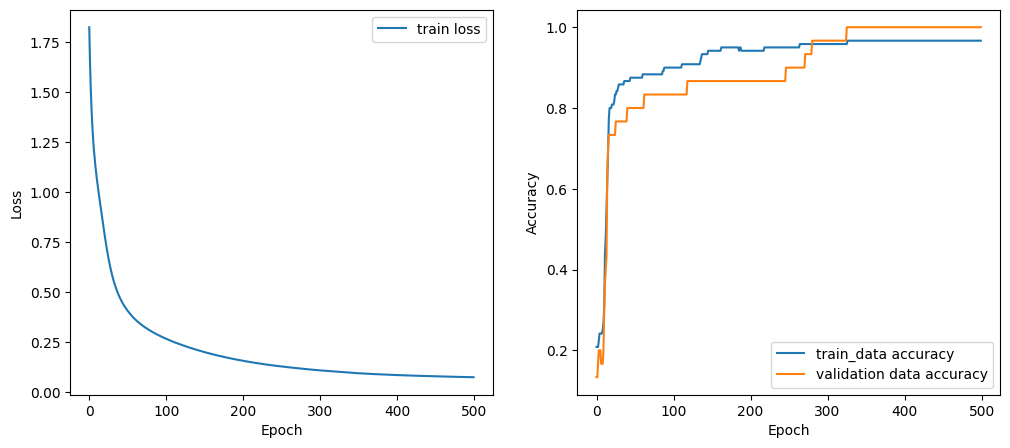

## dataset:mnist  x_train:56000 x_test:14000 y_train:56000 y_test:14000


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 784)                 │         615,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           7,850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 623,290 (2.38 MB)

 Trainable params: 623,290 (2.38 MB)

 Non-trainable params: 0 (0.00 B)

ストリーミング出力は最後の 5000 行に切り捨てられました。
y_test[9001] [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] -> pred_test[9001] [0.00000, 0.00001, 0.00000, 0.00000, 0.99998, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000]
y_test[9002] [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] -> pred_test[9002] [0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.99998, 0.00002]
y_test[9003] [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] -> pred_test[9003] [0.00000, 0.00000, 0.00000, 0.00000, 1.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000]
y_test[9004] [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] -> pred_test[9004] [0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 1.00000, 0.00000, 0.00000]
y_test[9005] [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] -> pred_test[9005] [0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 1.00000, 0.00000, 0.00000]
y_test[9006] [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] -> pred_test[9006] [0.00000, 0.00000, 0.00000, 0.00000, 0.00100, 0.00000, 0.00000, 0.00016, 0.00000, 0.99883]
y_test[9007] [0. 0. 0. 1. 0. 0. 0. 0. 

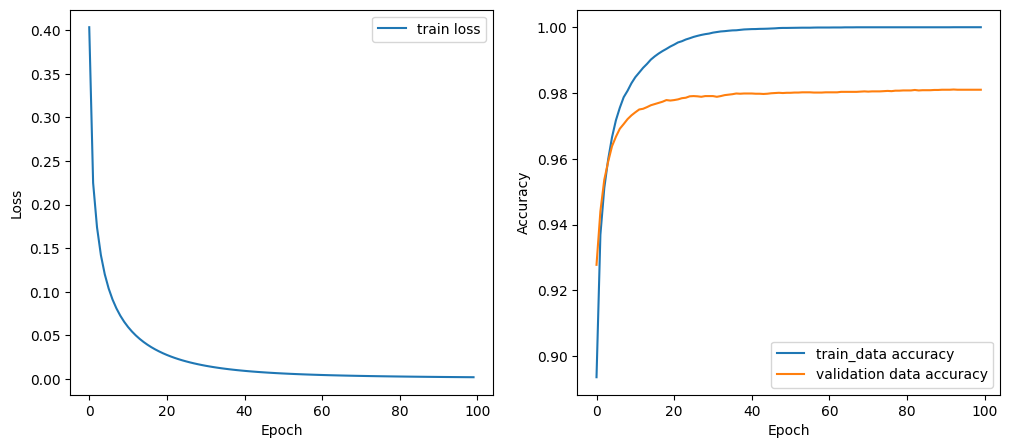

## dataset:fashon-mnist  x_train:56000 x_test:14000 y_train:56000 y_test:14000


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 784)                 │         615,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           7,850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 623,290 (2.38 MB)

 Trainable params: 623,290 (2.38 MB)

 Non-trainable params: 0 (0.00 B)

ストリーミング出力は最後の 5000 行に切り捨てられました。
y_test[9001] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] -> pred_test[9001] [0.00000, 1.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000]
y_test[9002] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] -> pred_test[9002] [0.99438, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00562, 0.00000, 0.00000, 0.00000]
y_test[9003] [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] -> pred_test[9003] [0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.99962, 0.00000, 0.00037, 0.00000, 0.00000]
y_test[9004] [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] -> pred_test[9004] [0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 1.00000, 0.00000, 0.00000, 0.00000]
y_test[9005] [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] -> pred_test[9005] [0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00042, 0.00000, 0.99795, 0.00000, 0.00163]
y_test[9006] [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] -> pred_test[9006] [0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 1.00000, 0.00000]
y_test[9007] [0. 0. 0. 0. 0. 0. 0. 0. 

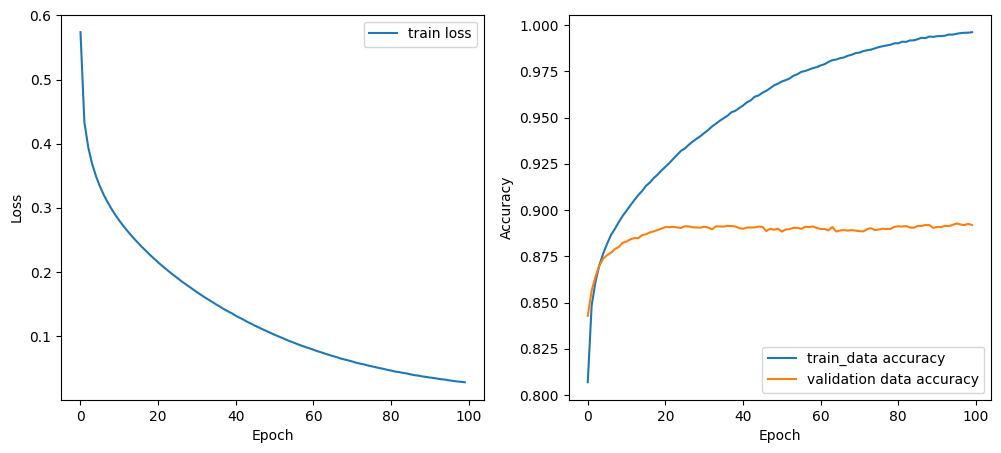

In [3]:
# 辞書に格納したデータセットそれぞれについて性能を確認]
feature_num = {'iris': 4, 'mnist': 784, 'fashon-mnist': 784}
target_num = {'iris': 3, 'mnist': 10, 'fashon-mnist': 10}
epoch_num = {'iris': 500, 'mnist': 100, 'fashon-mnist': 100}
for dataset_key in dataset.keys():
    x_train, x_test, y_train, y_test = dataset[dataset_key]
    print(f'## dataset:{dataset_key} ',
        f'x_train:{len(x_train)} x_test:{len(x_test)} y_train:{len(y_train)} y_test:{len(y_test)}')

    # 入力変数を標準化・出力変数はone-hotベクトル化
    if dataset_key == "iris":
        # 標準化
        x_train = preprocessing.scale(x_train)
        x_test = preprocessing.scale(x_test)
    else:
        # 正規化
        x_train = x_train / 255.0
        x_test = x_test / 255.0
    y_train = np.eye(target_num[dataset_key])[y_train].squeeze()  # (10, 3)
    y_test = np.eye(target_num[dataset_key])[y_test].squeeze()  # (30, 3)

    # ニューラルネットワークのモデルの作成・サマリの表示
    tf.random.set_seed(1)
    model = tf.keras.models.Sequential(name='model')
    model.add(tf.keras.Input(shape=(feature_num[dataset_key],)))
    model.add(tf.keras.layers.Dense(units=feature_num[dataset_key], activation='relu'))
    model.add(tf.keras.layers.Dense(units=target_num[dataset_key], activation='softmax'))
    model.summary()

    # 学習時の設定・学習の実施 (損失関数・最適化関数・評価関数)
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                            epochs=epoch_num[dataset_key], batch_size=10, verbose=0, shuffle=True,
                            validation_data=(x_test, y_test))

    # 予測結果の出力
    pred_test = model.predict(x_test)
    for i in range(len(pred_test)):
        print(f'y_test[{i}] {y_test[i]} -> pred_test[{i}] [{", ".join(f"{pred_test[i][num]:.5f}" for num in range(target_num[dataset_key]))}]')

    # 性能(正答率)の評価
    train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=0)
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f'{dataset_key} accuracy score: train data > {train_accuracy:.5f}, test data > {test_accuracy:.5f}')

    # 学習状況の可視化
    fig, ax = plt.subplots(1,2,figsize=(12,5))
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].plot(history.history['loss'], label='train loss')
    ax[0].legend(loc='upper right')
    ax[1].plot(history.history['accuracy'], label='train_data accuracy')
    ax[1].plot(history.history['val_accuracy'], label='validation data accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(loc='lower right')
    plt.show()

| モデル   | パラメータ                             | Iris    | MNIST   | Fashion-MNIST |
|----------|---------------------------------------|---------|---------|---------------|
| kNN      | $k=3$                                 | 0.96667 | 0.97229 | 0.8565 |
| kNN      | $k=3$，標準化                         | 0.96667 | 0.94629 | 0.85586 |
| SVM      | kernel="linear", c=1                  | 0.96667 | 0.84421 | 0.70507 |
| SVM      | kernel="linear", c=1, 標準化          | 0.96667 | 0.92214 | 0.81029 |
| SVM      | kernel="rbf", c=1                     | 0.96667 | 0.98043 | 0.89179 |
| SVM      | kernel="rbf", c=1, 標準化             | 0.96667 | 0.96607 | 0.89607 |
| DT       | max_depth=10                          | 0.96667 | 0.85386 | 0.81064 |
| DT       | max_depth=10, 標準化                  | 0.96667 | 0.85386 | 0.81043 |
| RF       | max_depth=10, n_estimators=100        | 0.96667 | 0.94879 | 0.85279 |
| RF       | max_depth=10, n_estimators=100, 標準化| 0.96667 | 0.94886 | 0.85286 |
| AB       | max_depth=10, n_estimators=170        | 0.96667 | 0.96229 | 0.85786 |
| AB       | max_depth=10, n_estimators=170, 標準化| 0.96667 | 0.96229 | 0.85786 |
| GBDT     | max_depth=10, n_estimators=170        | 0.96667 | 0.97357 | 0.89871 |
| GBDT     | max_depth=10, n_estimators=170, 標準化| 0.96667 | 0.97364 | 0.8985 |
| NN (3)   | middle=ReLU, output=softmax           | 1.00000 | 0.98100 | 0.89186 |

Irisに関しては，NN(3)のみ精度が100％となったが，testデータが少なく時間の都合でNN(3)だけ別のtestデータで検証することとなったためである可能性があり，NNのモデルの良さであるかは分からない．MNISTに関しては，以前の最良モデルであるrbfカーネルのSVMよりも高精度となり，より非線形な特徴を上手く識別できるモデルであることが分かる．Fashion-MNISTに関して，GBDTには届かないもののほぼ同程度の高精度となった．ただし，中間層の数が1つでありここを増やし，深層学習を行うことでより高精度かつある程度汎用的なモデルとなることが考えられる．あるいは，中間層のネットワークにさらなる工夫が必要であると考えられる．

### 2. 畳み込みニューラルネットワーク（CNN）の検証
　畳み込みニューラルネットワーク（CNN）とは，人間の視覚の神経ネットワークをモデル化し，機械学習ネットワークに応用したものであり，ある幅（窓）のデータとフィルタ関数を畳み込み演算し，最大プーリングを行うことでデータの特徴をネットワークに落とし込む方法を用いたニューラルネットワークである．

## dataset:iris  x_train:120 x_test:30 y_train:120 y_test:30


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 3, 32)               │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 1, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 195 (780.00 B)

 Trainable params: 195 (780.00 B)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
y_test[0] [0. 0. 1.] -> pred_test[0] [0.07455, 0.00223, 0.92322]
y_test[1] [1. 0. 0.] -> pred_test[1] [0.54292, 0.42008, 0.03700]
y_test[2] [0. 1. 0.] -> pred_test[2] [0.04465, 0.91993, 0.03542]
y_test[3] [1. 0. 0.] -> pred_test[3] [0.73751, 0.08563, 0.17685]
y_test[4] [1. 0. 0.] -> pred_test[4] [0.83312, 0.02429, 0.14259]
y_test[5] [1. 0. 0.] -> pred_test[5] [0.91665, 0.01659, 0.06676]
y_test[6] [0. 0. 1.] -> pred_test[6] [0.00610, 0.07830, 0.91560]
y_test[7] [0. 0. 1.] -> pred_test[7] [0.23028, 0.05506, 0.71466]
y_test[8] [0. 0. 1.] -> pred_test[8] [0.01645, 0.28612, 0.69743]
y_test[9] [0. 1. 0.] -> pred_test[9] [0.25393, 0.36599, 0.38008]
y_test[10] [1. 0. 0.] -> pred_test[10] [0.92644, 0.00020, 0.07336]
y_test[11] [0. 1. 0.] -> pred_test[11] [0.32635, 0.59324, 0.08041]
y_test[12] [0. 0. 1.] -> pred_test[12] [0.04672, 0.04340, 0.90988]
y_test[13] [0. 1. 0.] -> pred_test[13] [0.83961, 0.14148, 0.01891]
y_test[14] [0. 0. 1.] -> pred_test[14] [0.1

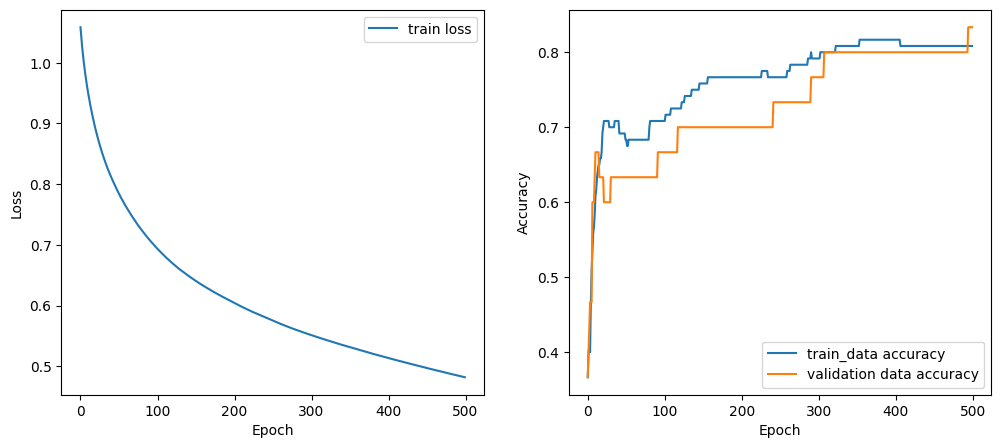

## dataset:mnist  x_train:56000 x_test:14000 y_train:56000 y_test:14000


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 5408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 10)                  │          54,090 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,410 (212.54 KB)

 Trainable params: 54,410 (212.54 KB)

 Non-trainable params: 0 (0.00 B)

ストリーミング出力は最後の 5000 行に切り捨てられました。
y_test[9001] [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] -> pred_test[9001] [0.00000, 0.00000, 0.00000, 0.00000, 0.99995, 0.00000, 0.00000, 0.00005, 0.00000, 0.00000]
y_test[9002] [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] -> pred_test[9002] [0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 1.00000, 0.00000]
y_test[9003] [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] -> pred_test[9003] [0.00000, 0.00000, 0.00000, 0.00000, 1.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000]
y_test[9004] [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] -> pred_test[9004] [0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 1.00000, 0.00000, 0.00000]
y_test[9005] [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] -> pred_test[9005] [0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 1.00000, 0.00000, 0.00000]
y_test[9006] [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] -> pred_test[9006] [0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 1.00000]
y_test[9007] [0. 0. 0. 1. 0. 0. 0. 0. 

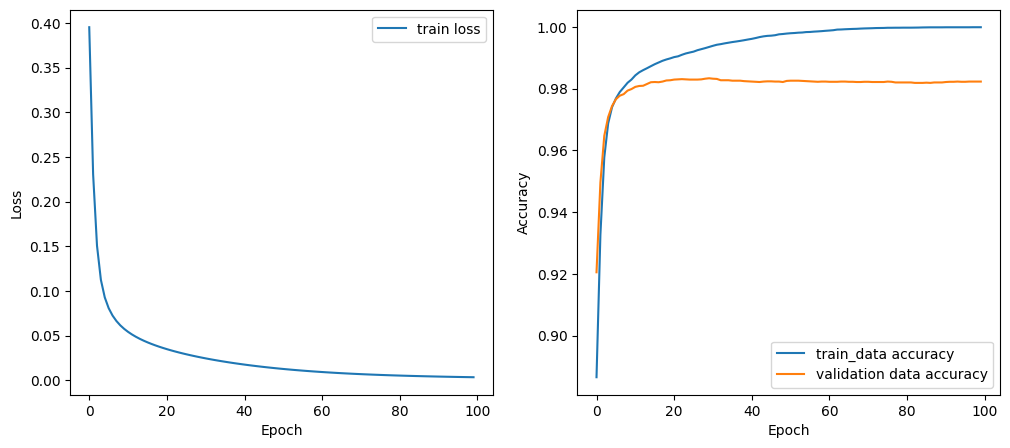

## dataset:fashon-mnist  x_train:56000 x_test:14000 y_train:56000 y_test:14000


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 5408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 10)                  │          54,090 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,410 (212.54 KB)

 Trainable params: 54,410 (212.54 KB)

 Non-trainable params: 0 (0.00 B)

ストリーミング出力は最後の 5000 行に切り捨てられました。
y_test[9001] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] -> pred_test[9001] [0.00000, 1.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000]
y_test[9002] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] -> pred_test[9002] [0.99995, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00005, 0.00000, 0.00000, 0.00000]
y_test[9003] [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] -> pred_test[9003] [0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.99926, 0.00000, 0.00074, 0.00000, 0.00000]
y_test[9004] [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] -> pred_test[9004] [0.00036, 0.00000, 0.00007, 0.00000, 0.00037, 0.00000, 0.99920, 0.00000, 0.00000, 0.00000]
y_test[9005] [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] -> pred_test[9005] [0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00003, 0.00000, 0.99817, 0.00000, 0.00180]
y_test[9006] [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] -> pred_test[9006] [0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 1.00000, 0.00000]
y_test[9007] [0. 0. 0. 0. 0. 0. 0. 0. 

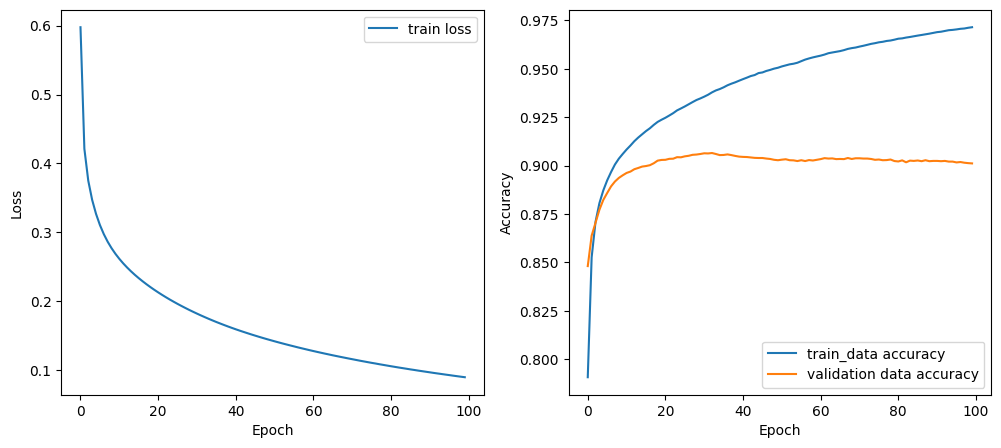

In [7]:
# 辞書に格納したデータセットそれぞれについて性能を確認]
feature_num = {'iris': 4, 'mnist': 784, 'fashon-mnist': 784}
target_num = {'iris': 3, 'mnist': 10, 'fashon-mnist': 10}
epoch_num = {'iris': 500, 'mnist': 100, 'fashon-mnist': 100}
for dataset_key in dataset.keys():
    x_train, x_test, y_train, y_test = dataset[dataset_key]
    print(f'## dataset:{dataset_key} ',
        f'x_train:{len(x_train)} x_test:{len(x_test)} y_train:{len(y_train)} y_test:{len(y_test)}')

    # 入力変数を標準化・出力変数はone-hotベクトル化
    if dataset_key == "iris":
        # 標準化
        x_train = preprocessing.scale(x_train)
        x_test = preprocessing.scale(x_test)
        x_train = x_train.reshape(-1, feature_num['iris'], 1)  # Conv1Dのため1次元に整形
        x_test = x_test.reshape(-1, feature_num['iris'], 1)
    else:
        # 正規化
        x_train = x_train / 255.0
        x_test = x_test / 255.0
        x_train = x_train.reshape(-1, 28, 28, 1)  # Conv2D用に28x28x1に整形
        x_test = x_test.reshape(-1, 28, 28, 1)
    y_train = np.eye(target_num[dataset_key])[y_train].squeeze()  # (10, 3)
    y_test = np.eye(target_num[dataset_key])[y_test].squeeze()  # (30, 3)

    # CNNを用いたニューラルネットワークのモデルの作成・サマリの表示
    tf.random.set_seed(1)
    model = tf.keras.models.Sequential(name='model')
    if dataset_key == 'iris':
        model.add(tf.keras.Input(shape=(feature_num[dataset_key], 1)))
        model.add(tf.keras.layers.Conv1D(32, 2, activation='relu'))
        model.add(tf.keras.layers.MaxPooling1D(2))
        model.add(tf.keras.layers.Flatten())
    else:
        model.add(tf.keras.Input(shape=(28, 28, 1)))
        model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))
        model.add(tf.keras.layers.Flatten())
    # model.add(tf.keras.layers.Dense(units=64, activation='relu'))
    model.add(tf.keras.layers.Dense(units=target_num[dataset_key], activation='softmax'))

    # モデルサマリの表示
    model.summary()


    # 学習時の設定・学習の実施 (損失関数・最適化関数・評価関数)
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                            epochs=epoch_num[dataset_key], batch_size=10, verbose=0, shuffle=True,
                            validation_data=(x_test, y_test))

    # 予測結果の出力
    pred_test = model.predict(x_test)
    for i in range(len(pred_test)):
        print(f'y_test[{i}] {y_test[i]} -> pred_test[{i}] [{", ".join(f"{pred_test[i][num]:.5f}" for num in range(target_num[dataset_key]))}]')

    # 性能(正答率)の評価
    train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=0)
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f'{dataset_key} accuracy score: train data > {train_accuracy:.5f}, test data > {test_accuracy:.5f}')

    # 学習状況の可視化
    fig, ax = plt.subplots(1,2,figsize=(12,5))
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].plot(history.history['loss'], label='train loss')
    ax[0].legend(loc='upper right')
    ax[1].plot(history.history['accuracy'], label='train_data accuracy')
    ax[1].plot(history.history['val_accuracy'], label='validation data accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(loc='lower right')
    plt.show()

| モデル   | パラメータ                             | Iris    | MNIST   | Fashion-MNIST |
|----------|---------------------------------------|---------|---------|---------------|
| kNN      | $k=3$                                 | 0.96667 | 0.97229 | 0.8565 |
| kNN      | $k=3$，標準化                         | 0.96667 | 0.94629 | 0.85586 |
| SVM      | kernel="linear", c=1                  | 0.96667 | 0.84421 | 0.70507 |
| SVM      | kernel="linear", c=1, 標準化          | 0.96667 | 0.92214 | 0.81029 |
| SVM      | kernel="rbf", c=1                     | 0.96667 | 0.98043 | 0.89179 |
| SVM      | kernel="rbf", c=1, 標準化             | 0.96667 | 0.96607 | 0.89607 |
| DT       | max_depth=10                          | 0.96667 | 0.85386 | 0.81064 |
| DT       | max_depth=10, 標準化                  | 0.96667 | 0.85386 | 0.81043 |
| RF       | max_depth=10, n_estimators=100        | 0.96667 | 0.94879 | 0.85279 |
| RF       | max_depth=10, n_estimators=100, 標準化| 0.96667 | 0.94886 | 0.85286 |
| AB       | max_depth=10, n_estimators=170        | 0.96667 | 0.96229 | 0.85786 |
| AB       | max_depth=10, n_estimators=170, 標準化| 0.96667 | 0.96229 | 0.85786 |
| GBDT     | max_depth=10, n_estimators=170        | 0.96667 | 0.97357 | 0.89871 |
| GBDT     | max_depth=10, n_estimators=170, 標準化| 0.96667 | 0.97364 | 0.8985 |
| LightDBM | max_depth=10, n_estimators=170        | 0.96667 | 0.98057 | 0.90286 |
| LightDBM | max_depth=10, n_estimators=170, 標準化| 0.93333 | 0.98014 | 0.9035 |
| NN (3)   | middle=ReLU, output=softmax           | 1.00000 | 0.98100 | 0.89186 |
| CNN (3)  | middle=ReLU, output=softmax           | 0.83333 | 0.98229 | 0.90114 |

CNNを用いたことにより，MNISTはLightGBMやrbfカーネルのSVMよりも更に高精度となった．Fashion-MNISTに関しても，LightGBM並みの90%越えの精度となった．それとは対称的にIrisに関しては精度が悪化した．これから分かることは，CNNを用いることによって非線形なデータや複雑な特徴を持つデータを上手く分類することは可能になったが，線形な特徴を持つ単純なデータを分類できるとは限らず，データの特徴からモデルの複雑さを正しく選定する必要があるといえる．時間の都合で行わないが，更に高精度を目指すには，CNNを用い中間層の数を多くした深層学習を行う必要があることが示唆される．

### 感想  
　中間層の数を多くした深層学習を行うことで，比較的汎用的なモデルとなることが示唆された．しかし，この方法は学中に膨大な時間がかかり，更に学習過程・結果がブラックボックスとなってしまうことが予測される．また，内部の学習結果がGBDTやLightGBM似たような結果となっている可能性も考えられ，その場合はGBDTやLightGBMを用いた方が学習時間と学習結果の可視性の両観点で優れるといえる．